Importando bibliotecas utilizadas

In [1]:
import datasets
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Leitura dos dados

In [2]:
dataset = datasets.load_from_disk("../dataset")

Informações sobre o dataset. Colunas e número de linhas.

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})

Convertendo para dataframe do pandas

In [4]:
df_train = pd.DataFrame(dataset['train'])
df_validation = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

Limpando dados sem informação

In [5]:
df_train[df_train['tokens'].apply(lambda x: len(x) == 0)]

,id,tokens,ner_tags
7827,7827,[],[]


In [6]:
df_train = df_train[df_train['tokens'].apply(lambda x: len(x) > 0)]
df_validation = df_validation[df_validation['tokens'].apply(lambda x: len(x) > 0)]
df_test = df_test[df_test['tokens'].apply(lambda x: len(x) > 0)]

Pré processamento para o formato necessário para utilização do modelo no keras

In [7]:
# Concatenar dataframes
df_concat = pd.concat([df_train, df_validation, df_test])

# Criar vocabulário de tokens únicos
tokens = np.concatenate(df_concat['tokens'].values)
unique_tokens = np.unique(tokens)

In [8]:
# Criar mapeamento de tokens para índices
token_to_index = {token: index for index, token in enumerate(unique_tokens)}

# Criar vocabulário de tags
tags = np.concatenate(df_concat['ner_tags'].values)
unique_tags = np.unique(tags)

# Criar mapeamento de tags para índices
tag_to_index = {tag: index for index, tag in enumerate(unique_tags)}

# Definir tamanho máximo de sequência de tokens
max_sequence_length = max(df_concat['tokens'].apply(len))

In [9]:
# Função para converter tokens para índices
def convert_to_indices(dataframe):
    token_indices = []
    tag_indices = []
    
    for tokens, tags in zip(dataframe['tokens'], dataframe['ner_tags']):
        token_indices.append([token_to_index[token] for token in tokens])
        tag_indices.append([tag_to_index[tag] for tag in tags])
    
    return token_indices, tag_indices


In [10]:
train_token_indices, train_tag_indices = convert_to_indices(df_train)
val_token_indices, val_tag_indices = convert_to_indices(df_validation)
test_token_indices, test_tag_indices = convert_to_indices(df_test)

In [11]:
# Fazer com que as sequências tenham o mesmo tamanho para serem usadas pelo tensor
train_token_indices = pad_sequences(train_token_indices, maxlen=max_sequence_length, padding='post')
train_tag_indices = pad_sequences(train_tag_indices, maxlen=max_sequence_length, padding='post')
val_token_indices = pad_sequences(val_token_indices, maxlen=max_sequence_length, padding='post')
val_tag_indices = pad_sequences(val_tag_indices, maxlen=max_sequence_length, padding='post')
test_token_indices = pad_sequences(test_token_indices, maxlen=max_sequence_length, padding='post')
test_tag_indices = pad_sequences(test_tag_indices, maxlen=max_sequence_length, padding='post')

In [12]:
# Usar one hot encodding para variáveis categóricas labels, criando variáveis dummies indicando a presença
# ou ausência dos labels mutualmente exclusivos
num_tags = len(unique_tags)
train_tag_indices = to_categorical(train_tag_indices, num_tags)
val_tag_indices = to_categorical(val_tag_indices, num_tags)
test_tag_indices = to_categorical(test_tag_indices, num_tags)

Arquitetura do modelo

In [13]:
# Arquitetura do modelo
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(unique_tokens), 128, input_length=max_sequence_length)(input_layer)
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
output_layer = TimeDistributed(Dense(num_tags, activation='softmax'))(lstm_layer)

In [14]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Resumo do modelo

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 755)]             0         
                                                                 
 embedding (Embedding)       (None, 755, 128)          2754432   
                                                                 
 bidirectional (Bidirectiona  (None, 755, 128)         98816     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 755, 13)          1677      
 ibuted)                                                         
                                                                 
Total params: 2,854,925
Trainable params: 2,854,925
Non-trainable params: 0
_________________________________________________________________


Ajustar modelo aos dados

In [ ]:
# Treinamento
model.fit(train_token_indices, train_tag_indices, validation_data=(val_token_indices, val_tag_indices), batch_size=32, epochs=10)

In [ ]:
#Salvar o modelo
model.save("./model.h5", save_format='h5')

In [19]:
# Ler modelo
model = load_model("./model.h5")

In [20]:
# Prever tags nos dados de teste
predictions = model.predict(test_token_indices)

# Remover padding
test_token_indices_no_padding = [tokens[:len(tokens)] for tokens in test_token_indices]

# Selecionar tag com maior score e transformá-la para o formato original
predicted_tag_indices = np.argmax(predictions, axis=-1)
predicted_tags = []

for i, row in enumerate(predicted_tag_indices):
    tokens = df_test['tokens'].iloc[i]
    original_length = len(tokens)
    predicted_tags.append([int(unique_tags[tag_index]) for tag_index in row[:original_length]])

# Adicionar previsão ao dataframe de testes
df_test['predicted_tags'] = predicted_tags

# Visualizar dados de teste
df_test.head()

44/44 [==============================] - 16s 318ms/step


,id,tokens,ner_tags,predicted_tags
0,0,"[Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...","[0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0, 11, 0, 12, 12, 0, 0, ..."
1,1,"[Interessado, /, Responsável, /, Recorrente, 3...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
2,2,"[Interessados/Responsáveis/Recorrentes, :, 3.1...","[0, 0, 0, 0]","[0, 0, 0, 0]"
3,3,"[Interessado, :, Superior, Tribunal, Militar, ...","[0, 0, 1, 2, 2, 0, 0, 0, 0, 0]","[0, 0, 1, 2, 2, 0, 0, 0, 0, 0]"
4,4,"[Responsáveis, :, Aldo, da, Silva, Fagundes, (...","[0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...","[0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ..."


Comparando previsão no id 0

In [21]:
np.array(df_test['ner_tags'][0]), np.array(df_test['predicted_tags'][0])

(array([ 0,  0,  0, 11, 12,  0,  1,  0,  3,  4, 11, 12,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  3,  4,  0]),
 array([ 0,  0,  0,  0,  0,  0,  1,  0, 11,  0, 12, 12,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]))

Comparando previsão no id 4

In [22]:
np.array(df_test['ner_tags'][4]), np.array(df_test['predicted_tags'][4])

(array([0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4,
        4, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 1, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0,
        0, 0]),
 array([0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4,
        4, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 1, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0,
        0, 0]))

Checando se número de previsões condiz com número de tokens

In [23]:
df_test['len_true'] = df_test['ner_tags'].apply(lambda x: len(x))
df_test['len_predicted'] = df_test['predicted_tags'].apply(lambda x: len(x))
df_test.head()

,id,tokens,ner_tags,predicted_tags,len_true,len_predicted
0,0,"[Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...","[0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 0, 11, 0, 12, 12, 0, 0, ...",38,38
1,1,"[Interessado, /, Responsável, /, Recorrente, 3...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",7,7
2,2,"[Interessados/Responsáveis/Recorrentes, :, 3.1...","[0, 0, 0, 0]","[0, 0, 0, 0]",4,4
3,3,"[Interessado, :, Superior, Tribunal, Militar, ...","[0, 0, 1, 2, 2, 0, 0, 0, 0, 0]","[0, 0, 1, 2, 2, 0, 0, 0, 0, 0]",10,10
4,4,"[Responsáveis, :, Aldo, da, Silva, Fagundes, (...","[0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...","[0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...",68,68


In [24]:
id2label = {
    0: "sem label",
    1: "B-ORGANIZACAO",
    2: "I-ORGANIZACAO",
    3: "B-PESSOA",
    4: "I-PESSOA",
    5: "B-TEMPO",
    6: "I-TEMPO",
    7: "B-LOCAL",
    8: "I-LOCAL",
    9: "B-LEGISLACAO",
    10: "I-LEGISLACAO",
    11: "B-JURISPRUDENCIA",
    12: "I-JURISPRUDENCIA"
}

Convertendo id para label

In [25]:
df_test['ner_tags'] = df_test['ner_tags'].apply(lambda tags: [id2label[tag_id] for tag_id in tags])
df_test['predicted_tags'] = df_test['predicted_tags'].apply(lambda tags: [id2label[tag_id] for tag_id in tags])
df_test.head()

,id,tokens,ner_tags,predicted_tags,len_true,len_predicted
0,0,"[Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...","[sem label, sem label, sem label, B-JURISPRUDE...","[sem label, sem label, sem label, sem label, s...",38,38
1,1,"[Interessado, /, Responsável, /, Recorrente, 3...","[sem label, sem label, sem label, sem label, s...","[sem label, sem label, sem label, sem label, s...",7,7
2,2,"[Interessados/Responsáveis/Recorrentes, :, 3.1...","[sem label, sem label, sem label, sem label]","[sem label, sem label, sem label, sem label]",4,4
3,3,"[Interessado, :, Superior, Tribunal, Militar, ...","[sem label, sem label, B-ORGANIZACAO, I-ORGANI...","[sem label, sem label, B-ORGANIZACAO, I-ORGANI...",10,10
4,4,"[Responsáveis, :, Aldo, da, Silva, Fagundes, (...","[sem label, sem label, B-PESSOA, I-PESSOA, I-P...","[sem label, sem label, B-PESSOA, I-PESSOA, I-P...",68,68


Criando vetores ground truth e predição para comparação

In [26]:
y_true = []
y_pred = []

for index, row in df_test.iterrows():
    y_true.extend(row['ner_tags'])
    y_pred.extend(row['predicted_tags'])

In [27]:
len(y_true), len(y_pred)

(47630, 47630)

Resultados

In [28]:
print('\nClassification Report')
print(classification_report(y_true, y_pred))


Classification Report
                  precision    recall  f1-score   support

B-JURISPRUDENCIA       0.75      0.44      0.56       185
    B-LEGISLACAO       0.86      0.78      0.82       378
         B-LOCAL       0.61      0.53      0.57        47
   B-ORGANIZACAO       0.85      0.72      0.78       501
        B-PESSOA       0.75      0.52      0.61       233
         B-TEMPO       0.76      0.36      0.49       192
I-JURISPRUDENCIA       0.79      0.61      0.69       475
    I-LEGISLACAO       0.93      0.87      0.90      2291
         I-LOCAL       0.42      0.20      0.27        85
   I-ORGANIZACAO       0.83      0.73      0.77       866
        I-PESSOA       0.93      0.73      0.82       502
         I-TEMPO       0.83      0.78      0.80        68
       sem label       0.97      0.99      0.98     41807

        accuracy                           0.96     47630
       macro avg       0.79      0.64      0.70     47630
    weighted avg       0.96      0.96      0.96

In [29]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        # change category codes or labels to new labels 
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    # calculate a confusion matrix with the new labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate row sums (for calculating % & plot annotations)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    # calculate proportions
    cm_perc = cm / cm_sum.astype(float) * 100
    # empty array for holding annotations for each cell in the heatmap
    annot = np.empty_like(cm).astype(str)
    # get the dimensions
    nrows, ncols = cm.shape
    # cycle over cells and create annotations for each cell
    for i in range(nrows):
        for j in range(ncols):
            # get the count for the cell
            c = cm[i, j]
            # get the percentage for the cell
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                # convert the proportion, count, and row sum to a string with pretty formatting
                annot[i, j] = '%d\n%.1f%%' % (c,p)
            elif c == 0:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d\n%.1f%%' % (c,p)
    # convert the array to a dataframe. To plot by proportion instead of number, use cm_perc in the DataFrame instead of cm
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Verdadeiro'
    cm.columns.name = 'Predição'
    # create empty figure with a specified size
    fig, ax = plt.subplots(figsize=figsize)
    # plot the data using the Pandas dataframe. To change the color map, add cmap=..., e.g. cmap = 'rocket_r'
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap = 'rocket_r')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #plt.savefig(filename)
    plt.show()


In [30]:
full_entities_list = sorted(list(set(id2label.values())))
entities_list = [item for item in full_entities_list if item != 'sem label']
np.array(full_entities_list), np.array(entities_list)

(array(['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO',
        'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO',
        'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO', 'sem label'],
       dtype='<U16'),
 array(['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO',
        'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO',
        'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO'], dtype='<U16'))

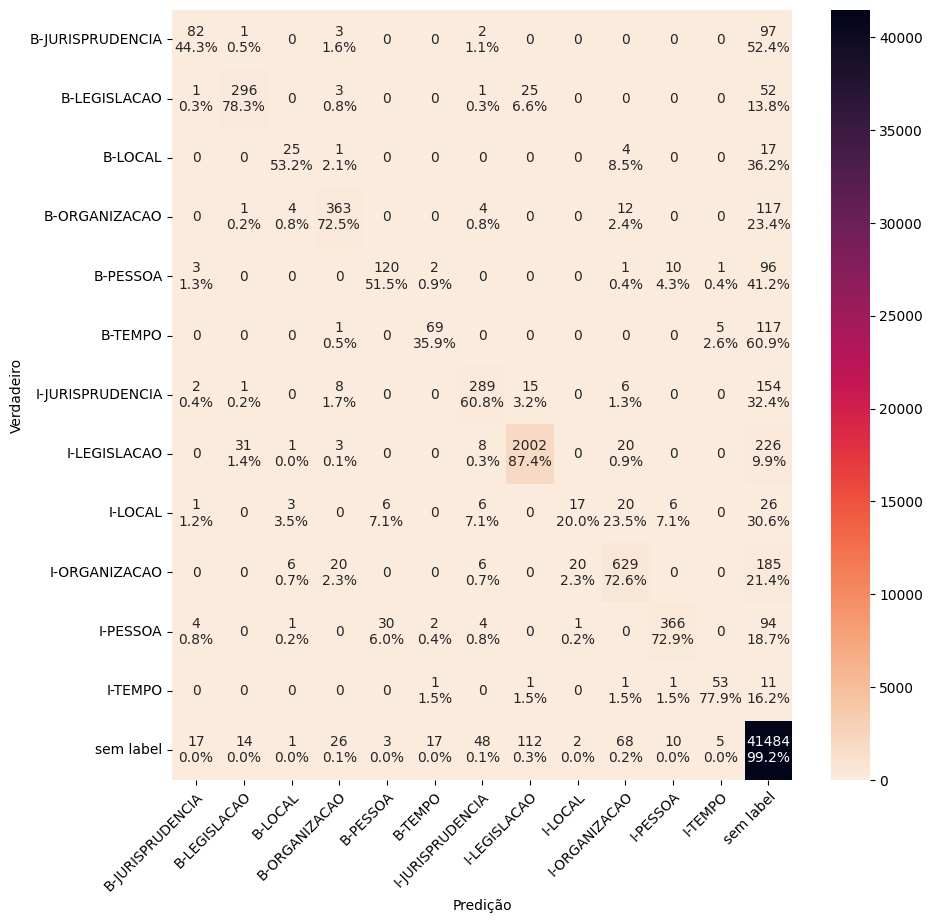

In [31]:
cm_analysis(y_true, y_pred, full_entities_list)

In [32]:
modified_y_true = [label[2:] if label.startswith("B-") or label.startswith("I-") else label for label in y_true]
modified_y_pred = [label[2:] if label.startswith("B-") or label.startswith("I-") else label for label in y_pred]
entities_list = np.unique(modified_y_true)
entities_list = [item for item in entities_list if item != 'sem label']

In [33]:
print('\nClassification Report')
print(classification_report(modified_y_true, modified_y_pred, labels = entities_list))


Classification Report
                precision    recall  f1-score   support

JURISPRUDENCIA       0.78      0.57      0.66       660
    LEGISLACAO       0.94      0.88      0.91      2669
         LOCAL       0.56      0.34      0.42       132
   ORGANIZACAO       0.86      0.75      0.80      1367
        PESSOA       0.95      0.72      0.82       735
         TEMPO       0.83      0.49      0.62       260

     micro avg       0.90      0.76      0.83      5823
     macro avg       0.82      0.62      0.70      5823
  weighted avg       0.89      0.76      0.82      5823

